# Fake News Detection - English

In [1]:
# Import libraries

# Main
import sys
sys.path.insert(0,'../')
import os
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm

# NLP
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import remove_stopwords
import nltk
nltk.download('wordnet')
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords

# Transformers
from transformers import AutoTokenizer, AutoModel, TFAutoModel

# Sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Display
from IPython.display import clear_output
clear_output()

### Loading data

In [2]:
from utils import Utils
utils = Utils('/media/juan/Juan/NLP/', num_workers=10)

In [3]:
# Define language
lang = 'en'

print('Starting...')

news_data, _ = utils.data_loader(lang, 'news', total_data=7500, max_size = None, return_dates = False)
fake_news_data, _ = utils.data_loader(lang, 'FakeNews', total_data=7500, max_size = None, return_dates = False)

print(f'Loaded {len(news_data)} news {len(fake_news_data)} fake news')

data = news_data + fake_news_data
tags = [1]*len(news_data) + [0]*len(fake_news_data)

Starting...
Starting 10 threads to load 7500 documents from news in en
Loaded 7500 files in 151.15 seconds.
Removed 0 files becasuse they were too large
Starting 10 threads to load 7500 documents from FakeNews in en
Loaded 7500 files in 0.74 seconds.
Removed 0 files becasuse they were too large
Loaded 7500 news 7500 fake news


### Glimpse at data

In [9]:
news_num = 2
print(news_data[news_num])
print('----------------------------------------------------------------------------------------------------------------------------------------------')
print(fake_news_data[news_num])

There was a huge emergency response to the incident, including police, air ambulance and paramedicsAn eight-year-old girl was rushed to hospital after a collision with a car on a busy Rhondda street near a school.A large emergency services presence flooded Maindy Road in Ton Pentre, near Ton Pentre Junior School, after the collision between a car and and a young girl at 3.20pm on Monday.Wales Air Ambulance, Welsh Ambulance Service and South Wales Police were all in attendance, and the casualty received treatment from helimeds, before being taken to Prince Charles Hospital by land ambulance for further treatment.The incident caused a significant tailback in traffic, with rows of cars left at a standstill.A spokesman for South Wales Police said: "Maindy Road in Ton Pentre was closed for approximately one hour following a collision between a car and an eight year-old girl at approximately 3.22pm today (Monday, 10 May, 2021)."The young girl sustained minor injuries and was taken to Prince 

### Basic classifiers with traditional feature extraction techniques

In [10]:
model_dict = {'NB': GaussianNB(), 
              'LR': LogisticRegression(random_state=0, max_iter = 700), 
              'MLP': MLPClassifier(hidden_layer_sizes=(500,250,100,20), random_state=1, max_iter=700),
              'SVM': svm.SVC()}
vectorizer_dict = {'tfidf': TfidfVectorizer(stop_words={'english'}, min_df = 30),
                   'count': CountVectorizer(stop_words={'english'}, min_df = 30)}

In [11]:
def create_features(vectorizer_type, data, tags):
    """ Return data and corresponding tags with data being features extracted with specified tokenizer
    
    Args:
        vectorizer_type (str): Vectorizer to use
        data (list): unprocessed corpus of data to extract features from
        tags (list): list of tags with same order as list
    
    Returns:
        np.ndarray: array with features of data
        list: tags with same order as data
    """
    vectorizer = vectorizer_dict[vectorizer_type]
    X = vectorizer.fit_transform(data).toarray()
    y = tags
    return X, y

def test_sklearn_models(model, metrics_df, X, y, vectorizer_type, val_percentage = 0.2):
    """ Train and evaluate model with specified arguments
    
    Args:
        model (str): Model to train
        metrics_df (pd.DataFrame): Dataframe to save the results
        X (np.ndarray): Features of data
        y (list): Tags of X
        vectorizer_type (str): Vectorizer used to extract features
        val_percentage (float): Validation percentage
    
    Returns:
        pd.DataFrame: Results of trained and evaluated model
    """
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=1-val_percentage)
    clf = model_dict[model]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    pre = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    data = {'model': [model], 'features': [vectorizer_type], 'lang': [lang], 'accuracy': [acc], 'precision': [pre], 'recall': [rec], 'f1': [f1]}
    df = metrics_df.append([pd.DataFrame(data=data)])
    return df

In [12]:
VECTORIZER_TYPE_ = ['tfidf', 'count']
MODEL_TPYE_ = ['NB', 'LR', 'MLP', 'SVM']
metrics = pd.DataFrame()
# metrics = pd.read_csv('./../../results/FakeNewsDetection/fake_news_detection_results.csv')
counter = 0
for vectorizer_type in VECTORIZER_TYPE_:
    X, y = create_features(vectorizer_type, data, tags)
    for model_type in MODEL_TPYE_:
        metrics = test_sklearn_models(model_type, metrics, X, y, vectorizer_type)
        print(f'Training {model_type} with {vectorizer_type} feature extraction')

Training NB with tfidf feature extraction
Training LR with tfidf feature extraction
Training MLP with tfidf feature extraction
Training SVM with tfidf feature extraction
Training NB with count feature extraction
Training LR with count feature extraction
Training MLP with count feature extraction
Training SVM with count feature extraction


In [13]:
metrics

,model,features,lang,accuracy,precision,recall,f1
0,NB,tfidf,en,0.857333,0.858966,0.854375,0.856664
0,LR,tfidf,en,0.949333,0.968707,0.928667,0.948264
0,MLP,tfidf,en,0.954000,0.936487,0.973064,0.954425
0,SVM,tfidf,en,0.970000,0.989316,0.948770,0.968619
0,NB,count,en,0.886333,0.867997,0.908356,0.887718
0,LR,count,en,0.951333,0.964191,0.940492,0.952194
0,MLP,count,en,0.963333,0.968037,0.960518,0.964263
0,SVM,count,en,0.921333,0.996100,0.846817,0.915412


In [14]:
metrics.to_csv('./../../results/FakeNewsDetection/fake_news_detection_results.csv')

<AxesSubplot:xlabel='model'>

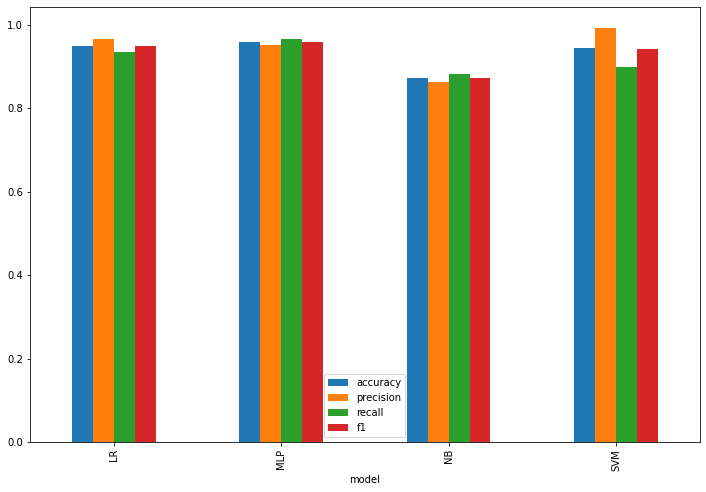

In [15]:
metrics.groupby('model').mean().plot.bar(figsize=(12,8))

<AxesSubplot:xlabel='features'>

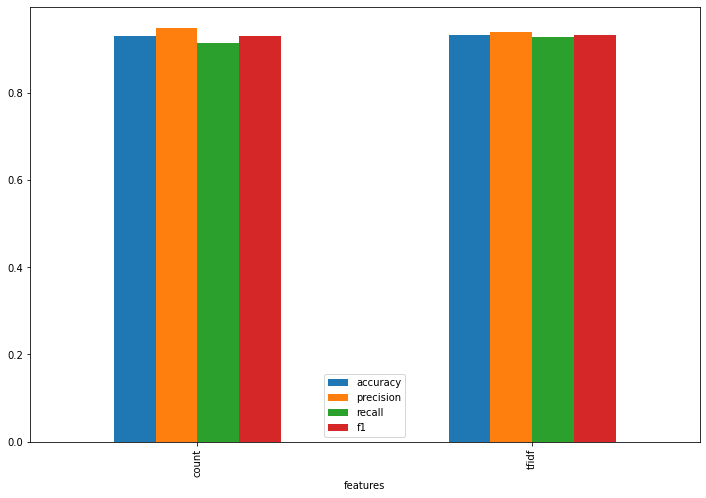

In [16]:
metrics.groupby('features').mean().plot.bar(figsize=(12,8))